<a href="https://colab.research.google.com/github/Dyakonov/Colab/blob/main/ART_ver55.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

MAIN_PATH = "/content/drive/My Drive/ART/"
MODEL_WEIGHTS = MAIN_PATH + "baseline55.pt"
TRAIN_DATASET = MAIN_PATH + "train/"
TRAIN_CSV = MAIN_PATH + "train.csv"

TEST_DATASET = MAIN_PATH + "test/"
H_FILENAME = MAIN_PATH + 'H55b.mtx' # НОМЕР
SUBMISSION_NAME = MAIN_PATH+ "submission55b.csv" #   НОМЕР


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
#torchvision.models.regnet_y_32gf
torch.cuda.is_available()
#!nvidia-smi

True

In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset

from PIL import Image
import os


import time
from tqdm import tqdm

In [ ]:
class F1_Loss(nn.Module):
    '''Calculate F1 score. Can work with gpu tensors

    The original implmentation is written by Michal Haltuf on Kaggle.

    Returns
    -------
    torch.Tensor
        `ndim` == 1. epsilon <= val <= 1

    Reference
    ---------
    - https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
    - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
    - https://discuss.pytorch.org/t/calculating-precision-recall-and-f1-score-in-case-of-multi-label-classification/28265/6
    - http://www.ryanzhang.info/python/writing-your-own-loss-function-module-for-pytorch/
    '''
    def __init__(self, epsilon=1e-7):
        super().__init__()
        self.epsilon = epsilon

    def forward(self, y_pred, y_true,):
        assert y_pred.ndim == 2
        assert y_true.ndim == 1
        y_true = torch.nn.functional.one_hot(y_true, 40).to(torch.float32) # ЧИСЛО КЛАССОВ
        y_pred = torch.nn.functional.softmax(y_pred, dim=1)

        tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
        tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)

        f1 = 2* (precision*recall) / (precision + recall + self.epsilon)
        f1 = f1.clamp(min=self.epsilon, max=1-self.epsilon)
        return 1 - f1.mean()

f1_loss = F1_Loss().cuda()

In [ ]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [ ]:
def set_requires_grad(model, value=False):
    for param in model.parameters():
        param.requires_grad = value


def train_model(model, dataloaders, criterion, optimizer,
                phases, num_epochs=3):
    start_time = time.time()

    acc_history = {k: list() for k in phases}
    loss_history = {k: list() for k in phases}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n_batches = len(dataloaders[phase])
            for inputs, labels in tqdm(dataloaders[phase], total=n_batches):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    if (np.random.rand(1)[0] < 0.5)&(phase == 'train'): # вероятность cutmix
                        lam = np.random.beta(2.0, 2.0)
                        rand_index = torch.randperm(inputs.size()[0]).to(device)
                        target_a = labels
                        target_b = labels[rand_index]
                        bbx1, bby1, bbx2, bby2 = rand_bbox(inputs.size(), lam)
                        inputs[:, :, bbx1:bbx2, bby1:bby2] = inputs[rand_index, :, bbx1:bbx2, bby1:bby2]
                        lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (inputs.size()[-1] * inputs.size()[-2]))

                        outputs = model(inputs)
                        loss = criterion(outputs, target_a) * lam + criterion(outputs, target_b) * (1. - lam)
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double()
            epoch_acc /= len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss,
                                                       epoch_acc))
            loss_history[phase].append(epoch_loss)
            acc_history[phase].append(epoch_acc)

        print()

    time_elapsed = time.time() - start_time
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60,
                                                        time_elapsed % 60))

    return model, acc_history

In [ ]:
def init_model(device, num_classes):
    model = torchvision.models.convnext_small(weights='IMAGENET1K_V1') # regnet_y_400mf .mobilenet_v3_small
    ##### print (model)
    set_requires_grad(model, False)
    model.classifier[2] = torch.nn.Linear(model.classifier[2].in_features,
                                          num_classes)
    for t in model.classifier.parameters(): # LayerNorm УДАЛИЛ [0]
        t.requires_grad = True
    # model.fc = torch.nn.Linear(in_features=model.fc.in_features, out_features=num_classes, bias=True)
    model = model.to(device)
    return model

In [ ]:
class ArtDataset(Dataset):
    def __init__(self, root_dir, csv_path=None, transform=None):

        self.transform = transform
        self.files = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir)]
        self.targets = None
        if csv_path:
            df = pd.read_csv(csv_path, sep="\t")
            self.targets = df["label_id"].tolist()
            self.files = [os.path.join(root_dir, fname) for fname in df["image_name"].tolist()]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        image = Image.open(self.files[idx]).convert('RGB')
        target = self.targets[idx] if self.targets else -1
        if self.transform:
            image = self.transform(image)
        return image, target

In [ ]:
# random_state = 55 # NEW
img_size_0 = 336
img_size = 224
trans = transforms.Compose([
    transforms.Resize((img_size_0, img_size_0)),
    # transforms.RandomRotation(degrees=(-5, 5)),
    transforms.ColorJitter(brightness=0.075, contrast=0.075, saturation=0.075, hue=0.075),
    transforms.RandomCrop(size=(img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

dset = ArtDataset(TRAIN_DATASET, TRAIN_CSV, trans)
labels = dset.targets
#indices = list(range(len(labels)))
#ind_train, ind_test, _, _ = train_test_split(indices, labels, test_size=0.1,
#                                             random_state=random_state,
#                                             stratify=labels)

#trainset = torch.utils.data.Subset(dset, ind_train)
#testset = torch.utils.data.Subset(dset, ind_test)

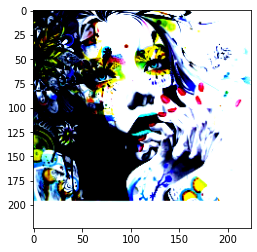

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(dset[0][0].permute(1, 2, 0))

In [ ]:
# torchvision.models.

In [ ]:
batch_size = 256 ### 32 256
num_workers = 4
trainloader = torch.utils.data.DataLoader(dset, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)

#testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
#                                         shuffle=False) ######, num_workers=num_workers)

loaders = {'train': trainloader} #, 'val': testloader}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = init_model(device, num_classes=40)

pretrain_optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.01) # classifier[3]
# SGD(model.classifier[3].parameters(), lr=0.001, momentum=0.9)
train_optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# SGD(model.parameters(), lr=0.001, momentum=0.9)

criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Pretrain
num_epochs=2
# запустить предобучение модели на две эпохи
pretrain_results = train_model(model, loaders, criterion, pretrain_optimizer,
                               phases=['train'], num_epochs=num_epochs) # , 'val'

Epoch 0/1
----------


  0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
<ipython-input-6-838de3351049>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_w = np.int(W * cut_rat)
<ipython-input-6-838de3351049>:6: DeprecationWarning: `np.int` 

train Loss: 1.3298 Acc: 0.7122

Epoch 1/1
----------


  0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
  6%|▋         | 4/62 [01:09<11:10, 11.57s/it]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
 19%|█▉        | 12/62 [02:57<08:08,  9.77s/it]/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 52%|█████▏    | 32/62 [07:28<04:33,  9.12s/it]/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 73%|███████▎  | 45/62 [11:00<05:34, 19.69s/it]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corr

train Loss: 1.0970 Acc: 0.7158

Training complete in 46m 14s


In [ ]:
torch.save(model.state_dict(), "/content/drive/My Drive/ART/w1.plt")

In [ ]:
for g in pretrain_optimizer.param_groups:
    g['lr'] = 0.001

#pretrain_optimizer.param_groups
#= torch.optim.Adam(model.classifier.parameters(), lr=0.01) # classifier[3]
num_epochs=2
# запустить предобучение модели на две эпохи
pretrain_results = train_model(model, loaders, criterion, pretrain_optimizer,
                               phases=['train'], num_epochs=num_epochs)

Epoch 0/1
----------


  0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
  3%|▎         | 2/62 [01:03<26:57, 26.96s/it]  <ipython-input-6-838de3351049>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_w = np.int(W * cut_rat)
<ipython-input-6-838de3351049>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any

train Loss: 0.8590 Acc: 0.8158

Epoch 1/1
----------


  5%|▍         | 3/62 [01:16<18:21, 18.67s/it]/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
  8%|▊         | 5/62 [01:58<20:47, 21.88s/it]/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 35%|███▌      | 22/62 [05:36<09:53, 14.83s/it]/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 60%|█████▉    | 37/62 [08:48<04:44, 11.38s/it]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 byt

train Loss: 0.8537 Acc: 0.8295

Training complete in 27m 56s


In [ ]:
torch.save(model.state_dict(), "/content/drive/My Drive/ART/w2.plt")

In [ ]:
set_requires_grad(model, False)

#model.trunk_output.block4.requires_grad = True
#model.fc.requires_grad = True

for param in model.features[6].parameters():
    param.requires_grad = True

for param in model.features[7].parameters():
    param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True

import itertools

params = [model.features[6].parameters(), model.features[7].parameters(), model.classifier.parameters()]
train_optimizer = torch.optim.Adam(itertools.chain(*params), lr=0.001)

In [ ]:
num_epochs = 2 # !!!!!!!!

train_results = train_model(model, loaders, criterion, train_optimizer,
                            phases=['train'], num_epochs=num_epochs)

Epoch 0/1
----------


  0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-6-838de3351049>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/r

train Loss: 1.2341 Acc: 0.6907

Epoch 1/1
----------


  0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
 11%|█▏        | 7/62 [02:01<11:14, 12.27s/it]/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 13%|█▎        | 8/62 [02:05<08:50,  9.83s/it]/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 15%|█▍        | 9/62 [02:45<17:01, 19.27s/it]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
 29%|██▉       | 18/62 [04:41<10:46, 14.69s/it]/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with T

train Loss: 0.8538 Acc: 0.7951

Training complete in 28m 25s


In [ ]:
torch.save(model.state_dict(), "/content/drive/My Drive/ART/w3.plt")

In [ ]:
for g in train_optimizer.param_groups:
    g['lr'] = 0.0001

In [ ]:
num_epochs = 2 # !!!!!!!!

train_results = train_model(model, loaders, f1_loss, train_optimizer,
                            phases=['train'], num_epochs=num_epochs)

torch.save(model.state_dict(), "/content/drive/My Drive/ART/w4.plt")

Epoch 0/1
----------


  0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
<ipython-input-6-838de3351049>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_w = np.int(W * cut_rat)
<ipython-input-6-838de3351049>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, 

train Loss: 0.3676 Acc: 0.7944

Epoch 1/1
----------


  6%|▋         | 4/62 [01:13<11:38, 12.05s/it]/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 21%|██        | 13/62 [03:43<14:04, 17.24s/it]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
 26%|██▌       | 16/62 [03:57<06:47,  8.85s/it]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
 58%|█████▊    | 36/62 [08:38<04:08,  9.57s/it]/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 71%|███████   | 44/62 [10:32<02:53,  9.63s/it]/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette im

train Loss: 0.2900 Acc: 0.8397

Training complete in 28m 7s


In [ ]:
num_epochs = 2 # !!!!!!!!

train_results = train_model(model, loaders, f1_loss, train_optimizer,
                            phases=['train'], num_epochs=num_epochs)

torch.save(model.state_dict(), "/content/drive/My Drive/ART/w5.plt")

Epoch 0/1
----------


  0%|          | 0/62 [00:00<?, ?it/s]<ipython-input-6-838de3351049>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_w = np.int(W * cut_rat)
<ipython-input-6-838de3351049>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
De

train Loss: 0.2960 Acc: 0.8280

Epoch 1/1
----------


 13%|█▎        | 8/62 [02:02<08:39,  9.63s/it]/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 19%|█▉        | 12/62 [02:58<08:03,  9.68s/it]/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 44%|████▎     | 27/62 [06:32<06:48, 11.67s/it]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
 68%|██████▊   | 42/62 [10:21<05:17, 15.88s/it]/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 90%|█████████ | 56/62 [13:17<01:00, 10.06s/it]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarn

train Loss: 0.2939 Acc: 0.8269

Training complete in 28m 12s


In [ ]:
num_epochs = 2 # !!!!!!!!

train_results = train_model(model, loaders, f1_loss, train_optimizer,
                            phases=['train'], num_epochs=num_epochs)

torch.save(model.state_dict(), "/content/drive/My Drive/ART/w6.plt")

Epoch 0/1
----------


  3%|▎         | 2/62 [01:06<28:21, 28.36s/it]  <ipython-input-6-838de3351049>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_w = np.int(W * cut_rat)
<ipython-input-6-838de3351049>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional infor

train Loss: 0.2630 Acc: 0.8502

Epoch 1/1
----------


  5%|▍         | 3/62 [01:08<16:26, 16.72s/it]/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 19%|█▉        | 12/62 [03:07<08:12,  9.85s/it]/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 34%|███▍      | 21/62 [05:36<13:30, 19.76s/it]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
 65%|██████▍   | 40/62 [09:22<03:28,  9.47s/it]/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 82%|████████▏ | 51/62 [12:05<02:19, 12.71s/it]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarn

train Loss: 0.2702 Acc: 0.8656

Training complete in 27m 58s


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = init_model(device, num_classes=40)

Downloading: "https://download.pytorch.org/models/convnext_small-0c510722.pth" to /root/.cache/torch/hub/checkpoints/convnext_small-0c510722.pth


  0%|          | 0.00/192M [00:00<?, ?B/s]

In [ ]:
model.load_state_dict(torch.load("/content/drive/My Drive/ART/w6.plt"))
#model.eval()

<All keys matched successfully>

In [ ]:
batch_size = 256 ### 32 256
num_workers = 2
trainloader = torch.utils.data.DataLoader(dset, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)

#testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
#                                         shuffle=False) ######, num_workers=num_workers)

loaders = {'train': trainloader}

In [ ]:
set_requires_grad(model, True)

num_epochs = 4 # !!!!!!!!

train_optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

train_results = train_model(model, loaders, f1_loss, train_optimizer,
                            phases=['train'], num_epochs=num_epochs)

torch.save(model.state_dict(), "/content/drive/My Drive/ART/w7.plt")

Epoch 0/3
----------


  0%|          | 0/62 [00:00<?, ?it/s]<ipython-input-9-838de3351049>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_w = np.int(W * cut_rat)
<ipython-input-9-838de3351049>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
De

OutOfMemoryError: ignored

In [ ]:
import numpy as np

def getH(testset, testloader, model):
    m = len(testset)
    H = [] # np.zeros((m, m))
    y = [] # np.zeros(m)
    n_batches = len(testloader)
    model = model.eval()
    with torch.no_grad():
        for images, labels in tqdm(testloader, total=n_batches):
            y.extend(labels.cpu().numpy().tolist())
            images = images.to(device)
            outputs = model(images)
            H.append(outputs.cpu().numpy())
    H = np.concatenate(H, axis=0)
    y = np.array(y)
    return (H, y)

#H1, y = getH(testset, testloader, model)

In [ ]:
from sklearn.metrics import f1_score

def compute_metric(pred, gt):
    score = f1_score(gt, pred, average='macro')
    return score

def mysoftmax(H):
    return (np.exp(H)/np.exp(H).sum(axis=1)[:,np.newaxis])

In [ ]:
img_size_0 = 336
img_size = 224
trans = transforms.Compose([
    transforms.Resize((img_size_0, img_size_0)),
    # transforms.RandomRotation(degrees=(-5, 5)),
    transforms.ColorJitter(brightness=0.025, contrast=0.025, saturation=0.025, hue=0.025),
    transforms.RandomCrop(size=(img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

dset2 = ArtDataset(TEST_DATASET, transform=trans)

dset2loader = torch.utils.data.DataLoader(dset2, batch_size=batch_size,
                                         shuffle=False) #, num_workers=num_workers)

all_image_names = [item.split("/")[-1] for item in dset2.files]


# H1, _ = getH(dset2, testloader, model)

NameError: ignored

In [ ]:
model.eval()

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [ ]:
H = 0.0 # H1.copy()
for t in range(20):
    Hadd, _ = getH(dset2, dset2loader, model)
    H = H + Hadd
    print (f't={t} H1={Hadd[0,0]}')
H = H/20

  6%|▋         | 1/16 [02:00<30:07, 120.50s/it]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
100%|██████████| 16/16 [07:01<00:00, 26.34s/it]


t=0 H1=-0.3484051823616028


 81%|████████▏ | 13/16 [04:22<00:58, 19.47s/it]

In [ ]:

np.save(H_FILENAME, H)

In [ ]:
all_preds = H.argmax(axis=1)

In [ ]:

with open(SUBMISSION_NAME, "w") as f:
    f.write("image_name\tlabel_id\n")
    for name, cl_id in zip(all_image_names, all_preds):
        f.write(f"{name}\t{cl_id}\n")